![SuperHeroes](https://github.com/jorge-flores-py/Proyecto-Procesamiento-de-Datos/blob/main/images/Super_Heroes.png?raw=true "Proyecto PRO1 Procesamiento de Datos 2023")

## Procesamiento de Datos
En esta notebook vamos a realizar las operaciones de ETL, de manera tal que los datos queden preparados para la generación de reportes y presentación final.

### 1. Extracción de Datos
Una vez realizado el EDA, donde se efectuaron pequeñas correcciones complementarias, procederemos al procesamiento en si de los datos, el cual figuran en el archivo  Super Heroes.csv.

#### Objetivo

- Comprobar existencia de sesgos de genero según editoriales
- Verificar tendecia en cuanto a alineamiento por genero en cada editorial.
- Proporciones fisicas que maneja cada editorial.

In [1]:
#!pip install chart_studio
#!pip3 install wordcloud

In [1]:
# Importación de librerias basicas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import chart_studio.plotly as py
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
from plotly import tools

from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [2]:
# lectura del dataset
SH = pd.read_csv("Super Heroes.csv")
print(SH.shape)

(734, 11)


In [3]:
# Realizamos una preview de los datos
SH.head()

ID         Name Alignment Gender EyeColor               Race HairColor  \
0   0       A-Bomb      good   Male   yellow              Human   No Hair   
1   1   Abe Sapien      good   Male     blue      Icthyo Sapien   No Hair   
2   2     Abin Sur      good   Male     blue            Ungaran   No Hair   
3   3  Abomination       bad   Male    green  Human / Radiation   No Hair   
4   4      Abraxas       bad   Male     blue      Cosmic Entity     Black   

           Publisher SkinColor  Height  Weight  
0      Marvel Comics         -   203.0   441.0  
1  Dark Horse Comics      blue   191.0    65.0  
2          DC Comics       red   185.0    90.0  
3      Marvel Comics         -   203.0   441.0  
4      Marvel Comics         -   -99.0   -99.0

In [4]:
# Comprobaremos ahora la infoq ue nos devuelven los datos
SH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         734 non-null    int64  
 1   Name       734 non-null    object 
 2   Alignment  734 non-null    object 
 3   Gender     734 non-null    object 
 4   EyeColor   734 non-null    object 
 5   Race       734 non-null    object 
 6   HairColor  734 non-null    object 
 7   Publisher  719 non-null    object 
 8   SkinColor  734 non-null    object 
 9   Height     734 non-null    float64
 10  Weight     732 non-null    float64
dtypes: float64(2), int64(1), object(8)
memory usage: 63.2+ KB


A simple vista podemos ver que disponemos de un dataset bastante completo, que si bien puede poseer algunos datos faltantes, los mismos no hacen al objetivo que tenemos planteado. De todas formas estaremos realizando algunas transformaciones que son necesarias para el trabajo con variables numéricas.

In [5]:
# Ver cantidad de objetos faltantes
SH.isna().sum()

ID            0
Name          0
Alignment     0
Gender        0
EyeColor      0
Race          0
HairColor     0
Publisher    15
SkinColor     0
Height        0
Weight        2
dtype: int64

Como pudimos revisar en el EDA contamos con algunas variables que poseen valores nulos y otras que poseen datos rellenados sin ningún criterio, tal como podemos observar a continuación en las columnas altura y peso, donde encontramos muchas celdas con el valor **-99**.

In [6]:
# Columna ALTURA
SH['Height'].value_counts()

-99.0     135
 183.0     64
 188.0     57
 178.0     43
 180.0     41
         ... 
 108.0      1
 62.5       1
 195.0      1
 876.0      1
 66.0       1
Name: Height, Length: 72, dtype: int64

In [7]:
# Columna PESO
SH['Weight'].value_counts()

-99.0     162
 81.0      28
 54.0      27
 79.0      25
 90.0      21
         ... 
 4.0        1
 115.0      1
 268.0      1
 100.0      1
 17.0       1
Name: Weight, Length: 144, dtype: int64

Claramente se visualiza que en la columna Altura que existen 135 registros con el valor -99 y en la columna Peso 162 registros con el mismo valor. Vamos a asumir a los registros de estos campos como datos faltantes, los que luego NO descartaremos ya que la información que posee el resto del registro nos es relevante, sin embargo anticipamos que los mismos serán cambiados por un valor que no nos corrompa las medidas estadisticas.

Solo por curiosidad y para demostrar la carencia de transformación que posee el dataset, ejecutaremos un pairplot que sirve para verificar la cantidad de columnas numericas y la posible existencia de correlación entre ellas.

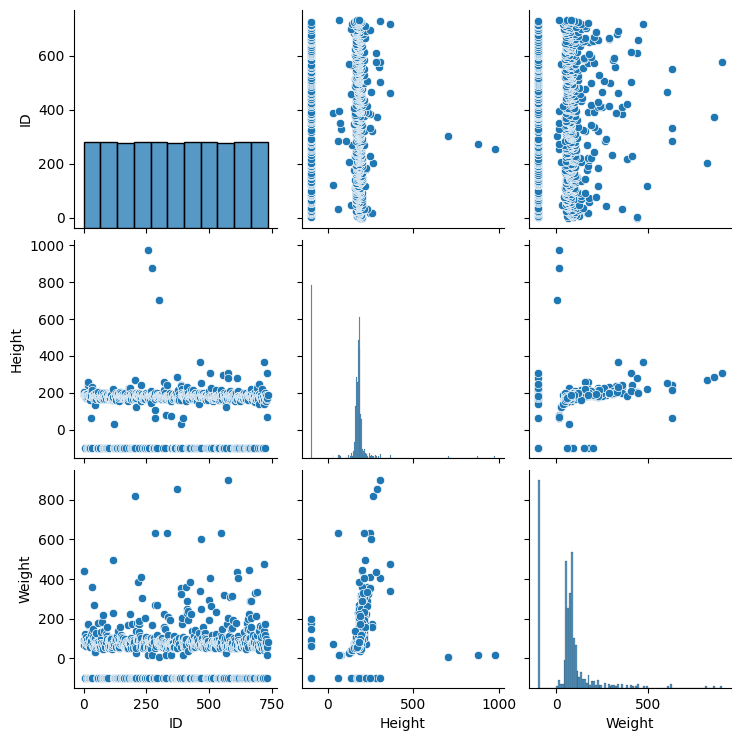

In [8]:
sns.pairplot(SH)

> **Se puede apreciar una correlación entre la altura y el peso, donde a mayor altura mayor es el peso.**

In [9]:
# Veremos el Super Heroes que mayor peso posee
SH[SH['Weight']== SH['Weight'].max()]

ID       Name Alignment Gender EyeColor Race HairColor      Publisher  \
575  575  Sasquatch      good   Male      red    -    Orange  Marvel Comics   

    SkinColor  Height  Weight  
575         -   305.0   900.0

---

### 1. Transformación de Datos
Comenzamos con la transformación de datos que ya sabemos que es mucha debido a que disponemos de muchas variables categóricas.

In [10]:
# Volvemos a ver la info del dataset
SH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         734 non-null    int64  
 1   Name       734 non-null    object 
 2   Alignment  734 non-null    object 
 3   Gender     734 non-null    object 
 4   EyeColor   734 non-null    object 
 5   Race       734 non-null    object 
 6   HairColor  734 non-null    object 
 7   Publisher  719 non-null    object 
 8   SkinColor  734 non-null    object 
 9   Height     734 non-null    float64
 10  Weight     732 non-null    float64
dtypes: float64(2), int64(1), object(8)
memory usage: 63.2+ KB


**Los pasos que vamos a realizar en este caso, sera eliminar aquellos campos que no son importantes para nuestro objetivo, renombrar columnas, transformar variables categóricas, cualquier otro cambio que sea necesario efectuar a medida que vamos transformando se indicará como es debido.**

In [11]:
# Eliminamos columna ID
SH.drop(['ID', 'EyeColor', 'HairColor'], axis=1, inplace=True)
SH.head()

Name Alignment Gender               Race          Publisher  \
0       A-Bomb      good   Male              Human      Marvel Comics   
1   Abe Sapien      good   Male      Icthyo Sapien  Dark Horse Comics   
2     Abin Sur      good   Male            Ungaran          DC Comics   
3  Abomination       bad   Male  Human / Radiation      Marvel Comics   
4      Abraxas       bad   Male      Cosmic Entity      Marvel Comics   

  SkinColor  Height  Weight  
0         -   203.0   441.0  
1      blue   191.0    65.0  
2       red   185.0    90.0  
3         -   203.0   441.0  
4         -   -99.0   -99.0

In [12]:
# Cambiamos los nombres de encabezados
SH.set_axis(['Nombre', 'Alineamiento', 'Genero', 'Raza', 'Editorial', 'Color de piel', 'Altura', 'Peso'], axis=1, inplace=True)
SH.columns

Index(['Nombre', 'Alineamiento', 'Genero', 'Raza', 'Editorial',
       'Color de piel', 'Altura', 'Peso'],
      dtype='object')

In [13]:
# Vemos la cantidad de Editoriales
SH.Editorial.unique()

array(['Marvel Comics', 'Dark Horse Comics', 'DC Comics', 'NBC - Heroes',
       'Wildstorm', 'Image Comics', nan, 'Icon Comics', 'SyFy',
       'Hanna-Barbera', 'George Lucas', 'Team Epic TV', 'South Park',
       'HarperCollins', 'ABC Studios', 'Universal Studios', 'Star Trek',
       'IDW Publishing', 'Shueisha', 'Sony Pictures', 'J. K. Rowling',
       'Titan Books', 'Rebellion', 'Microsoft', 'J. R. R. Tolkien'],
      dtype=object)

Anteriormente en la notebook habiamos comprobado que disponiamos de valores faltantes en la columna **`Editorial`** y con la salida del comando anterior confirmamos esto viendo la existencia de un valor llamado **`nan`**. Como esta columna es muy importante para nuestro análisis procederemos a eliminar dichos registros, pero antes listaremos los registros para ver con que sorpresa nos encontramos:

In [14]:
SH[SH['Editorial'].isnull()]

Nombre Alineamiento  Genero    Raza Editorial Color de piel  \
46          Astro Boy         good    Male       -       NaN             -   
86       Bionic Woman         good  Female  Cyborg       NaN             -   
138        Brundlefly            -    Male  Mutant       NaN             -   
175      Chuck Norris         good    Male       -       NaN             -   
204          Darkside          bad       -       -       NaN             -   
244        Ethan Hunt         good    Male   Human       NaN             -   
263      Flash Gordon         good    Male       -       NaN             -   
286          Godzilla          bad       -   Kaiju       NaN          grey   
348        Jack Bauer         good    Male       -       NaN             -   
354      Jason Bourne         good    Male   Human       NaN             -   
381  Katniss Everdeen         good  Female   Human       NaN             -   
389         King Kong         good    Male  Animal       NaN             -   
393      Kool-Aid Man         good    Male       -       NaN           red   
542             Rambo         good    Male   Human       NaN             -   
658          The Cape         good    Male       -       NaN             -   

     Altura  Peso  
46    135.0  30.0  
86    177.0  60.0  
138   193.0 -99.0  
175   178.0 -99.0  
204   -99.0 -99.0  
244   168.0 -99.0  
263   187.0  81.0  
286   108.0   NaN  
348   175.0  80.0  
354   -99.0 -99.0  
381   160.0 -99.0  
389    30.5   NaN  
393   -99.0 -99.0  
542   178.0  83.0  
658   -99.0 -99.0

En el listado vemos que la mayoria de los Super Héroes son de género masculino, muchos corresponden a películas y series y de ahí la razón que no figure Editorial alguna, sin embargo en dicho listado, nos encontramos con `Astro Boy` y `Flash Gordon` en los cuales su origen corresponde a comics, una mención aparte para `Darkseid`, que es un villano de la Editorial DC, que además de poseer valores faltantes, está mal escrito.

Estos errores pueden deberse a problemas al momento de cargar u obtener los datos; error humano al ingresar los datos o simplemente carecer de ellos, como el **`¿Que hacer ante errores faltantes?`** no es motivo de estudio en este trabajo y ya que no podemos devolver los datos para que nos los completen procederemos como ya se indicó antes, a la imputación o borrado de los mismos.

Cabe aclarar que podriamos guardar estos datos faltantes en otro dataframe por si son de utilidad a futuro, no consideramos esta opción ya que no aplica a nuestro objetivo.

In [15]:
# Antes de borrar revisamos la forma de nuestro Dataset
print(SH.shape)

(734, 8)


In [16]:
# Eliminimos los registro nulos filtrando por la columna Editorial
SH.dropna(subset=['Editorial'], inplace=True)

In [17]:
# Revisamos si tuvo efecto
SH[SH['Editorial'].isnull()]

Empty DataFrame
Columns: [Nombre, Alineamiento, Genero, Raza, Editorial, Color de piel, Altura, Peso]
Index: []

Vemos que ha tenido efecto la eliminación de los registros que presentaban valores faltantes en la columna **`Editorial`**

> Teniamos pensado dar el mismo tratamiento para los valores que figuran con nombre **-** dentro de la columna Alineamiento, pero consideramos dejarlo para luego mostrar como podemos evitar mostrarlos en una gráfica.

In [18]:
# Aqui mostramos los valores que presenta dicho campo
SH.Alineamiento.unique()

array(['good', 'bad', '-', 'neutral'], dtype=object)

----

A partir de ahora procederemos a la visualizacion de los elementos que poseemos en el Dataset y efectuar las gráficas que respondan a nuestro objetivo, el cual recordamos a continuación:

#### Objetivo

- Comprobar existencia de sesgos de género según editoriales
- Verificar tendencia en cuanto a alineamiento por género en cada editorial.
- Proporciones fisicas que maneja cada editorial.

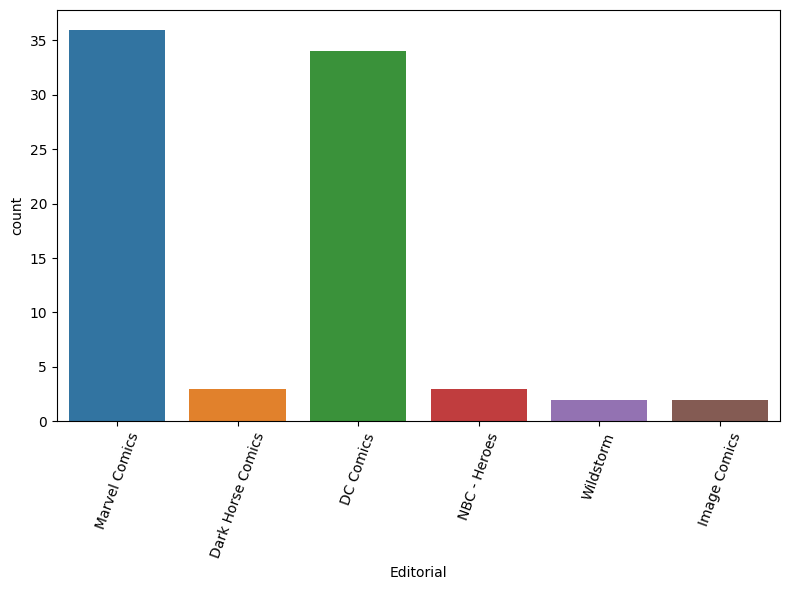

In [19]:
# Gráfica de Editoriales con Matplotlib
fig = plt.figure(figsize=(8,6))
fig.add_subplot(1,1,1)
sns.countplot(x="Editorial",data=SH.head(80))
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [20]:
# Misma grafica con Plotly
heroe_1 = SH["Editorial"].value_counts().head(80)

data_1 = [go.Bar(
    x=heroe_1.index,
    y=heroe_1.values
)]

layout = go.Layout(
    title="Editoriales con Más Héroes",
    xaxis=dict(title="Editorial"),
    yaxis=dict(title="Cantidad de Heroes"),
    showlegend=False
)

fig = go.Figure(data=data_1, layout=layout)

iplot(fig) 

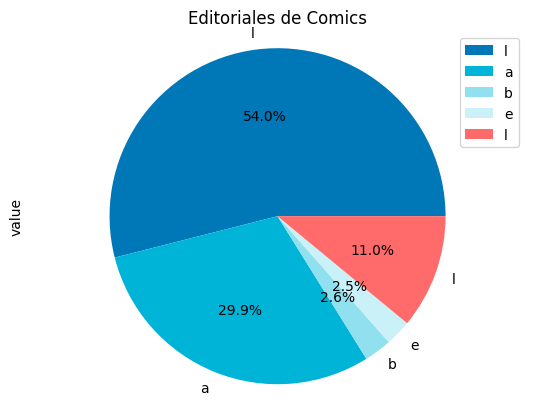

In [21]:
# Gráfica porcentual de Género por Editorial
heroe_2 = SH.Editorial.value_counts()
heroe_2 = pd.DataFrame(
    {"label": ["Marvel Comics", "DC Comics", "NBC - Heroes", "Dark Horse Comics", "Otras"],
    "value": heroe_2[:4].values.tolist() + [heroe_2[4:].sum()]}
)
heroe_2
colors = ["#0077B6", "#00B4D8", "#90E0EF", "#CAF0F8", "#FF6B6B"]
heroe_2.plot(kind="pie", labels="label", y="value", title="Editoriales de Comics", autopct="%1.1f%%", colors=colors)
plt.axis("equal")
plt.show() 

In [22]:
# Misma gráfica con Plotly
heroe = SH.Editorial.value_counts()
heroe = pd.DataFrame(
    {"label": ["Marvel Comics", "DC Comics", "NBC - Heroes", "Dark Horse Comics", "Otras"],
    "value": heroe[:4].values.tolist() + [heroe[4:].sum()]}
)
heroe
colors = ["#0077B6", "#00B4D8", "#90E0EF", "#CAF0F8", "#FF6B6B"]
data = [go.Pie(labels=heroe["label"], values=heroe["value"], hole=0.5, marker=dict(colors=colors))]

layout = go.Layout(title="Porcentual de Editoriales")
fig = go.Figure(data=data, layout=layout)

iplot(fig)       

#### Como podemos observar la libreria plotly nos devuelve unos gráficos con mayor funcionalidades y mejor definición por lo que continuaremos con esta librería en el resto de visualizaciones.

In [23]:
# Porcentual de alineamientos
heroe_3 = SH["Alineamiento"].value_counts()
df = pd.DataFrame({
    "label": heroe_3.index,
    "value": heroe_3.values
})
colors = ["#0077B6", "#00B4D8", "#FF6B6B"]
data = [go.Pie(labels=df["label"], values=df["value"], hole=0.4, marker=dict(colors=colors))]

layout = go.Layout(title="Porcentual de Alineamientos")
fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [24]:
# Porcentual de Masculinos/Femeninos
heroe_3 = SH["Genero"].value_counts()
df = pd.DataFrame({
    "label": heroe_3.index,
    "value": heroe_3.values
})
colors = ["#0077B6", "#00B4D8", "#FF6B6B"]
data = [go.Pie(labels=df["label"], values=df["value"], hole=0.4, marker=dict(colors=colors))]

layout = go.Layout(title="Porcentual de Género")
fig = go.Figure(data=data, layout=layout)

iplot(fig)

### Visualizar Punto 1 Objetivo
La gráfica a continuación nos muestra la respuesta al primer punto de nuestro objetivo:

In [26]:
top_Editoriales = SH["Editorial"].value_counts().nlargest(4).index
SH_filtrado = SH.copy()
SH_filtrado.loc[~SH_filtrado["Editorial"].isin(top_Editoriales), "Editorial"] = "Otras"

editorial_Counts = SH_filtrado.groupby(["Editorial", "Genero"]).size().unstack()

colors = ["#0077B6", "#00B4D8", "#FF6B6B"]
data = []
for genero in editorial_Counts.columns:
    data.append(go.Bar(
        x=editorial_Counts.index,
        y=editorial_Counts[genero],
        name=genero,
        text=editorial_Counts[genero].apply(lambda x: f"{x/editorial_Counts[genero].sum()*100:.2f}%"),
        textposition="outside",
        marker=dict(color=np.random.choice(colors))
    ))

layout = go.Layout(
    title="Porcentaje de SuperHéroes por Editorial según el Género",
    xaxis=dict(title="Editorial"),
    yaxis=dict(title="Porcentaje"),
    barmode="group",
    uniformtext=dict(mode="hide")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Como podemos apreciar se verifica un acentuado sesgo en cuanto a género, según editoriales, siendo **`Marvel Comics`** donde se acentúa mucho más esta diferencia entre géneros.

### Visualizar Punto 2 Objetivo
La grafica a continuación nos muestra la respuesta al segundo punto de nuestro objetivo:

In [27]:
top_Editoriales = SH["Editorial"].value_counts().nlargest(4).index
SH_filtrado = SH.copy()
SH_filtrado.loc[~SH_filtrado["Editorial"].isin(top_Editoriales), "Editorial"] = "Otras"

# Sacamos un conteo de los alineamientos según el género y la editorial
alineamiento_Counts = SH_filtrado.groupby(["Editorial", "Genero", "Alineamiento"]).size().unstack().reset_index()

# Creación de grafico de barras
data = []
#colors = ["#0077B6", "#00B4D8", "#FF6B6B"]
genero_colors = {"Male": "#1F77B4", "Female": "#FF6B6B"}

for genero in alineamiento_Counts["Genero"].unique():
    if genero != "-":
        df_genero = SH_filtrado.groupby(["Editorial", "Genero", "Alineamiento"]).size().unstack(level=[1, 2]).fillna(0)
        for editorial in top_Editoriales:
            df_editorial = df_genero.loc[editorial, genero].reset_index()
            df_editorial = df_editorial[df_editorial["Alineamiento"] != "-"]  # Eliminar valores de Alineamiento "-"
            x = df_editorial["Alineamiento"]
            y = df_editorial.iloc[:, 1:].values.flatten()

            data.append(go.Bar(
                x=x,
                y=y,
                name=f"{editorial} - {genero}",
                text=(y * 100).round(2),
                textposition="outside",
                marker=dict(color=genero_colors[genero])
            ))

layout = go.Layout(
    title="Tendencia de Alineamiento por Género en cada Editorial",
    xaxis=dict(title="Alineamiento"),
    yaxis=dict(title="Porcentaje"),
    barmode="group",
    uniformtext=dict(mode="hide")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Se pueden observar ciertas curiosidades en la gráfica, una de ellas es que nuevamente se destacan diferencias bien marcadas en **`Marvel Comics`** y esto se debe al gran porcentaje que dicha Editorial posee en el Dataset, esto tambien se aprecia en que el genero Femenino de héroes Buenos de **Marvel Comics** es casi igual a la cantidad del género Masculino de héroes buenos en **DC Comics**.

En el codigo se puede ver como evitamos graficar el Alineamiento que figura con nombre **-** el cual decidimos no elimanar del Dataset Original para mostrar que se puede hacer cuando necesitamos descartar de las gráficas un valor desconocido, dicha acción la evidenciamos en el comentario `# Eliminar valores de Alineamiento "-"`. Si se desea mostrar todos los alineamientos solo debemos comentar la linea completa donde se encuentra el comentario anterior resaltado.

### Visualizar Punto 3 Objetivo
La gráfica a continuación nos muestra la respuesta al tercer punto de nuestro objetivo:

Para el tercer punto de nuestro objetivo comenzaremos comparando el peso y la altura según el género. Aqui usaremos la otra librería de visualización llamada Seaborn.

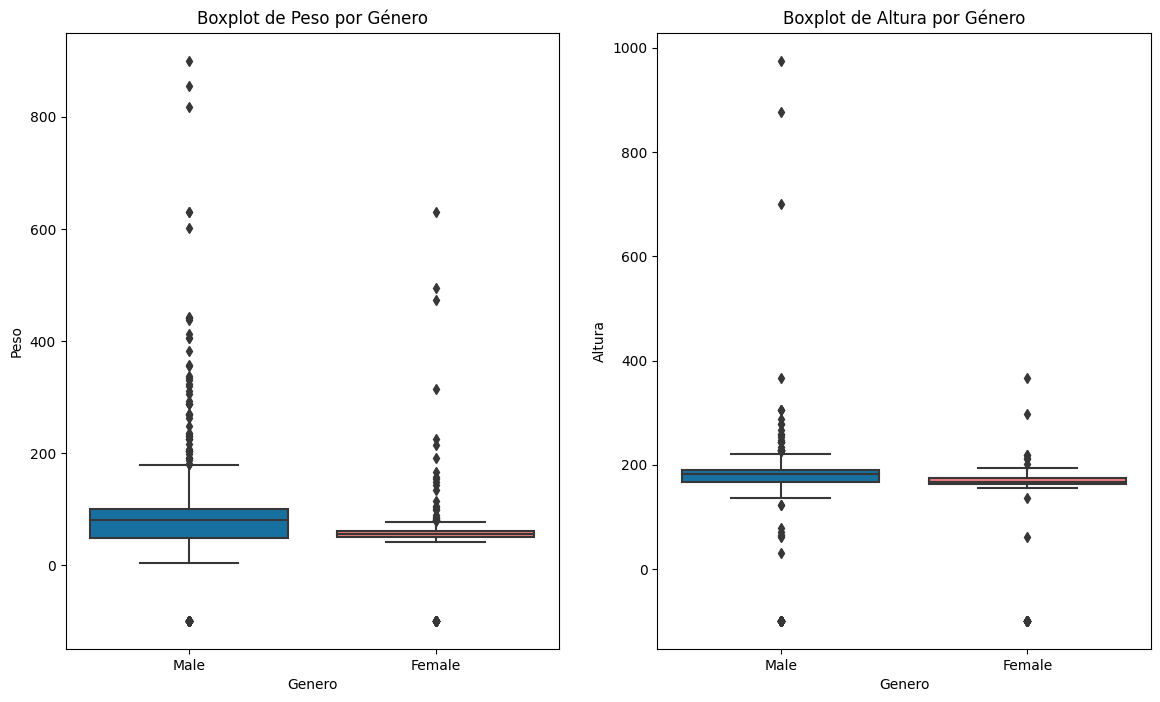

In [28]:
SH_filtrado = SH[SH["Genero"] != "-"]
colors = ["#0077B6", "#FF6B6B"]
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
sns.boxplot(x="Genero", y="Peso", data=SH_filtrado, ax=axes[0], palette=colors)
sns.boxplot(x="Genero", y="Altura", data=SH_filtrado, ax=axes[1], palette=colors)

# Leyendas

axes[0].set_title("Boxplot de Peso por Género")
axes[0].set_xlabel("Genero")
axes[0].set_ylabel("Peso")

axes[1].set_title("Boxplot de Altura por Género")
axes[1].set_xlabel("Genero")
axes[1].set_ylabel("Altura")

plt.show()

De la gráfica anterior y reforzando el concepto con la siguiente visualización, podemos denotar que la comparativa nos devuelve un serie de grupos bastante marcados y que podemos llegar a categorizar como `Pesados` y `Ligeros`.

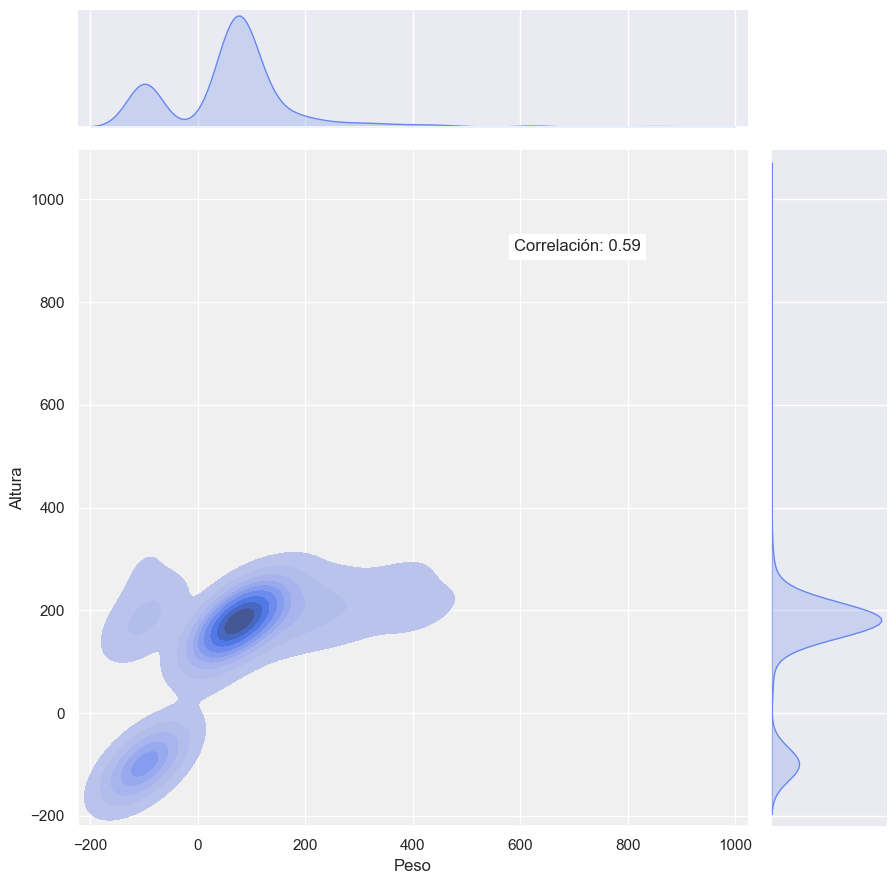

In [29]:
from scipy.stats import pearsonr

sns.set(style="darkgrid", palette="coolwarm")
g = sns.jointplot(x="Peso", y="Altura", data=SH, kind="kde", height=9, fill=True)
corr, _ = pearsonr(SH["Peso"], SH["Altura"]) #
g.ax_joint.annotate(f"Correlación: {corr:.2f}", xy=(0.65, 0.85), xycoords="axes fraction",
                    bbox=dict(boxstyle="square", fc="white"), fontsize=12)
g.set_axis_labels("Peso", "Altura", fontsize=12)
g.ax_joint.set_facecolor("#F0F0F0")
plt.show()

Esa división de grupos se puede evidenciar debido a que entre peso y altura parece existir una relación, a esta relación se la suele denominar correlación de variables, en la gráfica anterior utilizamos el coeficiente de correlacion de Pearson para su cálculo. La particularidad principal de la correlación de Pearson es que tiene una variación entre -1 y 1, cuando un valor es cercano a -1 indica una correlación negativa fuerte, y cuando un valor se acerque a 1 indicaría una correlación positiva fuerte, y un valor cercano a 0 indicaría una correlación débil o nula.

Aqui se puede acotar lo siguiente:

> **Un valor de 0 indica que no existe un `Correlacion Lineal` sin embargo puede existir otro tipo de relacion `No Lineal`**

Usando un grafico de `PairPlot` tambien podemos ver a simple vista si existe algun tipo de correlación entre variables sin tener que calcular el coeficiente previamente, esta existirá si vemos que los datos tienen a alinearse a una recta creciente o decreciente. Para el valor que obtuvimos antes de **0.59** se considera que NO es una relacxión muy fuerte, pero `MODERADA` por lo que aún sigue siendo considerable.

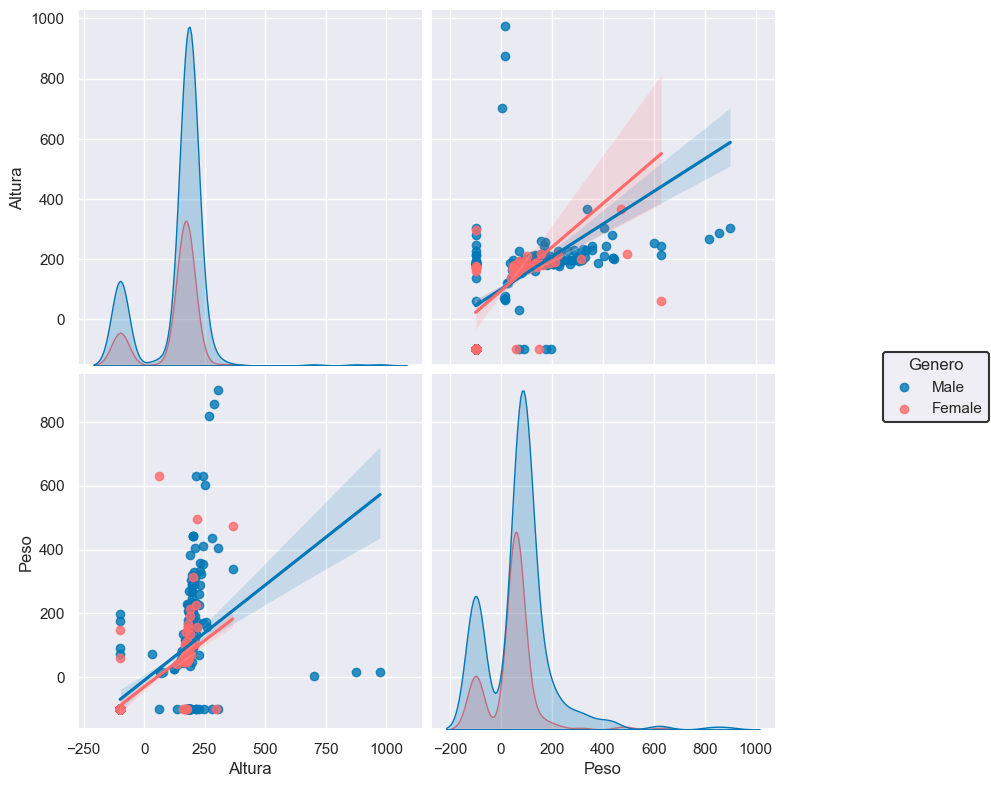

In [30]:
SH_filtered = SH[SH["Genero"] != "-"]
palette = ["#0077B6", "#FF6B6B"]
g = sns.pairplot(SH_filtered, kind="reg", height=4, hue="Genero", palette=palette)
legend = g._legend
legend.set_bbox_to_anchor((1.1, 0.5))
legend.set_frame_on(True)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")

plt.show()

Para obtener el gráfico de proporciones físicas por editorial utilizaremos un gráfico de violín el cual nos ayuda a mostrar la distribución a lo largo de un eje y la densidad estimadas de valores en el otro eje. Aqui cada violín representa una editorial y la forma del mismo representa la distribución de las proporciones físicas.

Vamos a comentar un poco el código ya que además aplicamos discretización para generar rangos, también llamados bins, lo cual nos permite convertir una variable numérica en categórica.

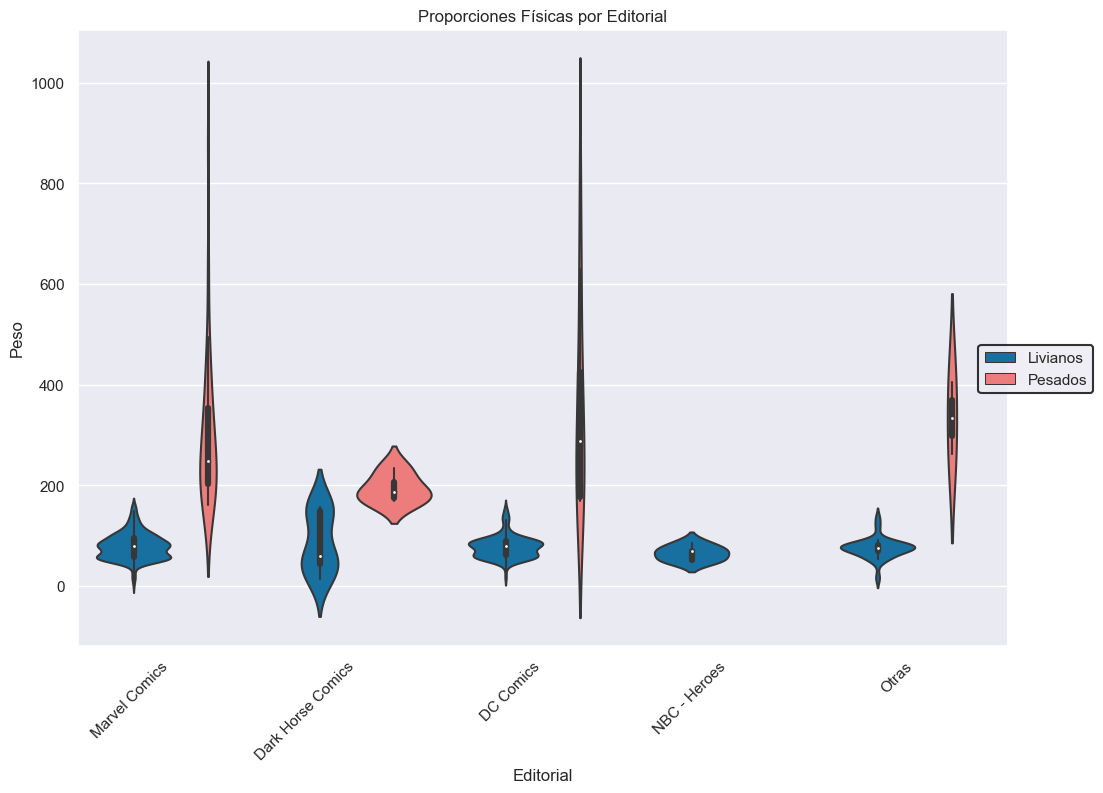

In [31]:
plt.figure(figsize=(12, 8))

# Crear la columna de categoría de peso (pesados y livianos)
SH["Categoria_Peso"] = pd.cut(SH["Peso"], bins=[0, 160, float("inf")], labels=["Livianos", "Pesados"])

# Generamos el TOP de editoriales
top_editoriales = SH["Editorial"].value_counts().nlargest(4).index

# Filtrar las 4 editoriales principales y agrupar el resto como "Otras"
SH_filtered = SH.copy()
SH_filtered.loc[~SH_filtered["Editorial"].isin(top_editoriales), "Editorial"] = "Otras"

palette = ["#0077B6", "#FF6B6B"]

# Generamos el gráfico de violín
g = sns.violinplot(x="Editorial", y="Peso", data=SH_filtered, hue="Categoria_Peso", palette=palette)

# Aplicamos estilos y títulos al gráfico
g.set_xlabel("Editorial")
g.set_ylabel("Peso")
g.set_title("Proporciones Físicas por Editorial")

# Reajustamos la ubicación de las leyendas
legend = g.legend()
legend.set_bbox_to_anchor((1.1, 0.5))
legend.set_frame_on(True)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")

# Acá aplicamos un giro a los valores de Editorial para evitar superposición
plt.xticks(rotation=45, ha="right")

plt.show()

Aqui podemos apreciar que la Editorial **`Dark Horse`** presenta una mejor distribución, más pareja en cuanto a proporciones físicas, esto nos indica que no posee Super Héroes con Dimensiones o Pesos demasiados ficticios y que aunque se exagere en cuanto a las medidas, no lo hace de forma extrema y muestra Héroes con proporciones humanas totalmente posibles.

Ahora bien, si bien no figura como parte de los objetivos de nuestro análisis, nos permitimos mostrar una gráfica muy interesante que releva la gran variedad de Razas que considera este dataset y que  podemos mostrar con una nube de palabras.

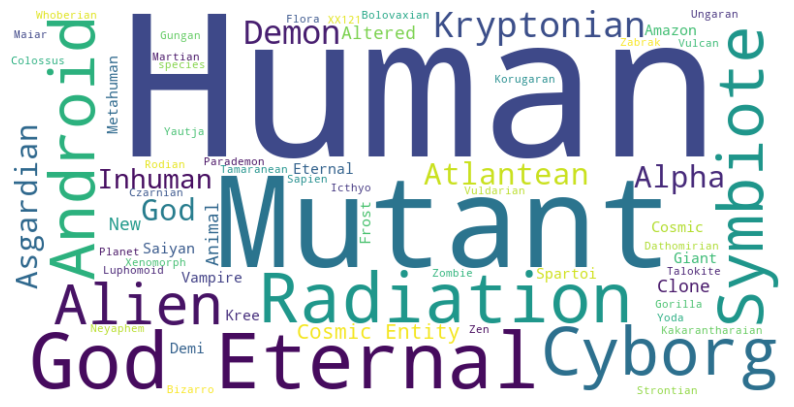

In [32]:
text_data = SH["Raza"].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
# Si queremos usar la misma paleta de color que venimos trabajando comentar la linea anterior y descomentar las siguientes

#colors = ["#0077B6", "#00B4D8", "#90E0EF", "#CAF0F8", "#FF6B6B"]
#plt.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colors[np.random.randint(0, len(colors))]), interpolation='bilinear')

plt.axis('off')
plt.show()

---

## CONCLUSION
 Podemos concluir  que las Editoriales con más héroes son: Marvel y DC Comics.
Alineamientos: el 67.3 es bueno, contra un 28.5 malo, de los cuales un 69 es de hombres y un 27.7 es de mujeres.
En el porcentaje de superhéroes por editorial segun el género, se sigue visualizando la tendencia en DC Comics y Marvel Comics que la mayoría de los superhéroes corresponden a personajes varones.
Finalmente se encontró una relación moderada entre el peso y la altura a pesar que hay diversidad de razas entre los superhéroes


In [33]:
SH.to_csv("SuperHeroes_transformado.csv", index=None, header=True)